# 네이버 영화 리뷰 감성분석 도전하기
- 데이터 출처: https://github.com/e9t/nsmc

#### 라이브러리 버전 확인

In [3]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


### 1) 데이터 준비와 확인

In [4]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) 데이터로더 구성
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [5]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words = 0

def load_data(train_data, test_data, num_words=num_words):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
    

In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [8]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


#### [오류] 데이터 입력시 '<PAD>' KeyError
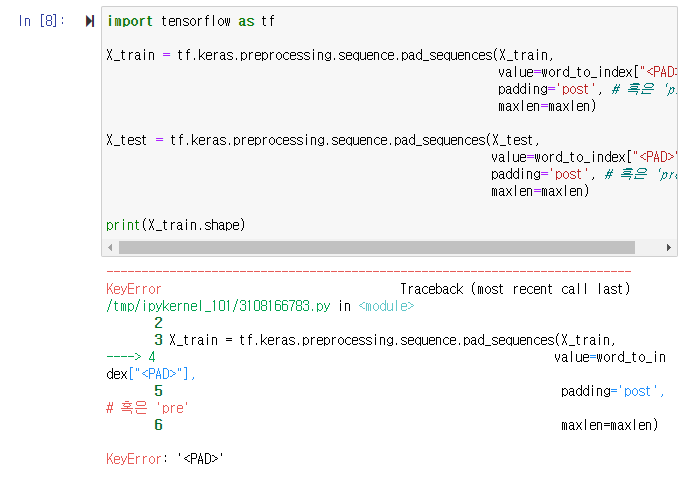

In [9]:
# 처음 몇 개 인덱스에 대해 사전 정의 해주어야 함.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3


In [10]:
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


### 4) 모델 구성 및 validation set 구성
- 모델 3가지 이상 테스트
1. 1-d cnn
2. lstm
3. cnn-lstm model

#### 1. 1-d cnn

In [11]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 8  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 8)           80000     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          912       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

### 5) 모델 훈련 개시

In [12]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [13]:
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
532/532 [==============================] - 6s 5ms/step - loss: 0.4419 - accuracy: 0.7863 - val_loss: 0.3420 - val_accuracy: 0.8514
Epoch 2/5
532/532 [==============================] - 2s 4ms/step - loss: 0.3195 - accuracy: 0.8644 - val_loss: 0.3341 - val_accuracy: 0.8559
Epoch 3/5
532/532 [==============================] - 2s 4ms/step - loss: 0.2850 - accuracy: 0.8823 - val_loss: 0.3331 - val_accuracy: 0.8537
Epoch 4/5
532/532 [==============================] - 2s 4ms/step - loss: 0.2576 - accuracy: 0.8966 - val_loss: 0.3440 - val_accuracy: 0.8532
Epoch 5/5
532/532 [==============================] - 2s 4ms/step - loss: 0.2329 - accuracy: 0.9089 - val_loss: 0.3551 - val_accuracy: 0.8517


In [14]:
results = model_cnn.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3711 - accuracy: 0.8479
[0.3710765838623047, 0.84787517786026]


In [15]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 6) Loss, Acc 그래프 시각화

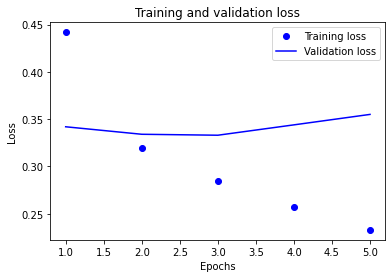

In [16]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

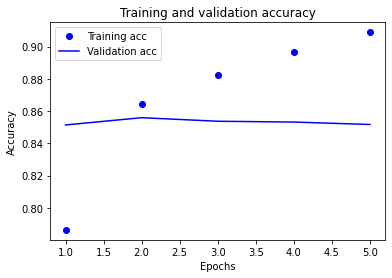

In [17]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 2. LSTM

In [18]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 10  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_lstm.add(tf.keras.layers.Dense(8, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 608       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 100,689
Trainable params: 100,689
Non-trainable params: 0
_________________________________________________________________


### 5) 모델 훈련 개시

In [19]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [20]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_lstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 4s 7ms/step - loss: 0.5889 - accuracy: 0.6654 - val_loss: 0.3943 - val_accuracy: 0.8372
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3548 - accuracy: 0.8507 - val_loss: 0.3432 - val_accuracy: 0.8531
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3237 - accuracy: 0.8644 - val_loss: 0.3450 - val_accuracy: 0.8526
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3133 - accuracy: 0.8699 - val_loss: 0.3408 - val_accuracy: 0.8525
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3069 - accuracy: 0.8722 - val_loss: 0.3430 - val_accuracy: 0.8522
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3000 - accuracy: 0.8757 - val_loss: 0.3419 - val_accuracy: 0.8509
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2956 - accuracy: 0.8777 - val_loss: 0.3487 - val_accuracy: 0.8502
Epoch 

In [21]:
results = model_lstm.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4266 - accuracy: 0.8438
[0.42655372619628906, 0.8437862396240234]


In [22]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 6) Loss, Acc 그래프 시각화

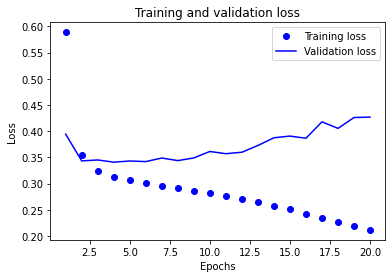

In [23]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

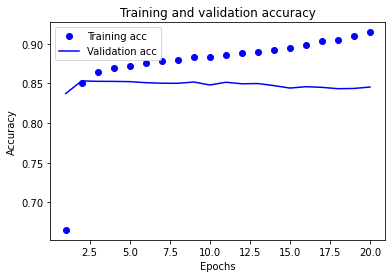

In [24]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 3. cnn-lstm model
- 참고자료: https://github.com/hongwon2/HG-MLDL/blob/main/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D2_%EA%B0%80%EC%A7%9C_%EB%89%B4%EC%8A%A4_%EB%B6%84%EB%A5%98_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8.ipynb

In [46]:
from tensorflow.keras.layers import LSTM, Dense

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_CNN_LSTM = tf.keras.Sequential()
model_CNN_LSTM.add(tf.keras.layers.Embedding(30000, 16))
model_CNN_LSTM.add(tf.keras.layers.Dropout(0.3))
model_CNN_LSTM.add(tf.keras.layers.Conv1D(32, 3, padding='same', strides=1,activation='relu'))
model_CNN_LSTM.add(tf.keras.layers.MaxPooling1D(2))
model_CNN_LSTM.add(LSTM(10))
model_CNN_LSTM.add(tf.keras.layers.Dropout(0.3))
model_CNN_LSTM.add(Dense(1, activation='sigmoid'))

model_CNN_LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          480000    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          1568      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                1720      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

### 5) 모델 훈련 개시

In [26]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [30]:
model_CNN_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_CNN_LSTM.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
532/532 [==============================] - 5s 7ms/step - loss: 0.4419 - accuracy: 0.7909 - val_loss: 0.3430 - val_accuracy: 0.8513
Epoch 2/20
532/532 [==============================] - 3s 6ms/step - loss: 0.3352 - accuracy: 0.8618 - val_loss: 0.3244 - val_accuracy: 0.8594
Epoch 3/20
532/532 [==============================] - 3s 6ms/step - loss: 0.3031 - accuracy: 0.8767 - val_loss: 0.3242 - val_accuracy: 0.8596
Epoch 4/20
532/532 [==============================] - 3s 6ms/step - loss: 0.2787 - accuracy: 0.8871 - val_loss: 0.3276 - val_accuracy: 0.8586
Epoch 5/20
532/532 [==============================] - 3s 6ms/step - loss: 0.2616 - accuracy: 0.8947 - val_loss: 0.3268 - val_accuracy: 0.8603
Epoch 6/20
532/532 [==============================] - 3s 6ms/step - loss: 0.2447 - accuracy: 0.9023 - val_loss: 0.3335 - val_accuracy: 0.8581
Epoch 7/20
532/532 [==============================] - 3s 6ms/step - loss: 0.2314 - accuracy: 0.9092 - val_loss: 0.3535 - val_accuracy: 0.8589
Epoch 

In [31]:
results = model_CNN_LSTM.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4422 - accuracy: 0.8491
[0.4421553611755371, 0.8490957617759705]


In [32]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 6) Loss, Acc 그래프 시각화

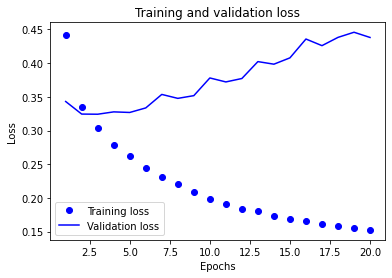

In [33]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

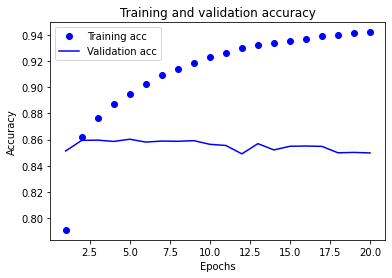

In [34]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석

In [47]:
embedding_layer = model_CNN_LSTM.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(30000, 16)


In [48]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_CNN_LSTM.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [50]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
import os

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['감독']

In [52]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors:
        embedding_matrix[i] = word_vectors[index_to_word[i]]

#### cnn-lstm 모델로 테스트

In [55]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_CNN_LSTM = tf.keras.Sequential()
model_CNN_LSTM.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_CNN_LSTM.add(tf.keras.layers.Dropout(0.3))
model_CNN_LSTM.add(tf.keras.layers.Conv1D(32, 3, padding='same', strides=1,activation='relu'))
model_CNN_LSTM.add(tf.keras.layers.MaxPooling1D(2))
model_CNN_LSTM.add(LSTM(10))
model_CNN_LSTM.add(tf.keras.layers.Dropout(0.3))
model_CNN_LSTM.add(Dense(1, activation='sigmoid'))

model_CNN_LSTM.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 16)            160000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 41, 16)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 41, 32)            1568      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 20, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                1720      
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

### 5) 모델 훈련 개시

In [56]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [58]:
# 하이퍼파라미터 설정
learning_rate = 0.001  # 원하는 학습률을 설정합니다.
epochs = 10  # 몇 epoch를 훈련할지 설정합니다.

# Adam 옵티마이저 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 모델 컴파일
model_CNN_LSTM.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 모델 훈련
history = model_CNN_LSTM.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)


Epoch 1/10
532/532 [==============================] - 5s 6ms/step - loss: 0.5919 - accuracy: 0.6328 - val_loss: 0.3730 - val_accuracy: 0.8380
Epoch 2/10
532/532 [==============================] - 3s 6ms/step - loss: 0.3669 - accuracy: 0.8436 - val_loss: 0.3419 - val_accuracy: 0.8526
Epoch 3/10
532/532 [==============================] - 3s 5ms/step - loss: 0.3310 - accuracy: 0.8616 - val_loss: 0.3313 - val_accuracy: 0.8557
Epoch 4/10
532/532 [==============================] - 3s 5ms/step - loss: 0.3110 - accuracy: 0.8723 - val_loss: 0.3274 - val_accuracy: 0.8603
Epoch 5/10
532/532 [==============================] - 3s 6ms/step - loss: 0.2965 - accuracy: 0.8789 - val_loss: 0.3281 - val_accuracy: 0.8581
Epoch 6/10
532/532 [==============================] - 3s 6ms/step - loss: 0.2844 - accuracy: 0.8848 - val_loss: 0.3263 - val_accuracy: 0.8579
Epoch 7/10
532/532 [==============================] - 3s 6ms/step - loss: 0.2732 - accuracy: 0.8898 - val_loss: 0.3294 - val_accuracy: 0.8602
Epoch 

In [59]:
results = model_CNN_LSTM.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3526 - accuracy: 0.8534
[0.35264164209365845, 0.8534491658210754]


In [60]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 6) Loss, Acc 그래프 시각화

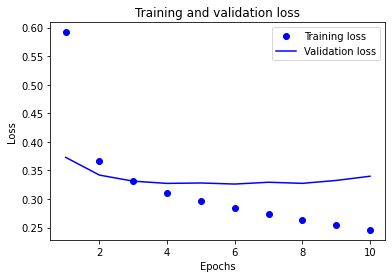

In [61]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

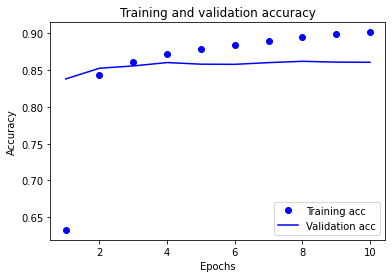

In [62]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 회고
- 단순히 노드 내용을 프로젝트로 옮기는 일 이였는데 굉장히 어려웠다.
- 코드 누락으로 인한 오류를 수정하면서 이해하지 못했던 내용을 알아갔다.
- 오전 학습에서 더 알아본 모델(CNN-LSTM 결합 모델)을 테스트 해보는 기회를 가졌다.